In [121]:
import pandas as pd
import numpy as np
import torch
import optuna
import torch.nn as nn
from torchsummary import summary
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from utils_pp import replace_cell_names_with_id
%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
# df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
# df_train["cell_line"]
# df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()

drug_data = pd.read_pickle("../data/drug_data.pkl.compress", compression="gzip")
cell_data = pd.read_pickle("../data/cell_line_data.pkl.compress", compression="gzip")
drug_data_val = drug_data.copy()
X_train_drug, X_val_drug, y_train_drug, y_val_drug = train_test_split(drug_data, drug_data_val, test_size=0.2, shuffle=True)
# df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
# df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
# df_train = df_train[df_train.cell_line.isin(cell_data.index)]
# df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
# cell_data = cell_data[cell_data.index.isin(pd.concat([df_train.cell_line, df_test.cell_line]))]
# print("oneil", df_train.memory_usage().sum()/1e6, df_train.shape,"\n", df_train.dtypes)
print("drug_feat", X_train_drug.memory_usage().sum()/1e6, X_train_drug.shape)
print("drug_feat", X_val_drug.memory_usage().sum()/1e6, X_val_drug.shape)
print("cell_feat", cell_data.memory_usage().sum()/1e6, cell_data.shape)


drug_feat 5.213636 (538, 2412)
drug_feat 1.324686 (135, 2412)
cell_feat 29.111364 (1450, 5011)


In [4]:
class dataset(Dataset):
    def __init__(self, data, labels):
        self.dataset = data.to_numpy()
        self.labels = labels.to_numpy()

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]
                
train_set_drug  = dataset(X_train_drug, y_train_drug)
val_set_drug  = dataset(X_val_drug, y_val_drug)
train_dl_drug = DataLoader(train_set_drug, batch_size=64, shuffle=True)
val_dl_drug = DataLoader(val_set_drug, batch_size=64, shuffle=True)
xi, yi = next(iter(train_dl_drug))
print(xi.shape, yi.shape)

torch.Size([64, 2412]) torch.Size([64, 2412])


In [103]:

# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self, h_sizes, dropout=0.2):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(h_sizes[0], h_sizes[1]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[1], h_sizes[2]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[2], h_sizes[3])
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(h_sizes[3], h_sizes[4]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[4], h_sizes[5]),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(h_sizes[5], h_sizes[0])
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
ae = AE([xi.shape[1],512,512,256,512,512])
yi = ae.forward(xi)
print(xi.shape, yi.shape)

torch.Size([128, 2412]) torch.Size([128, 2412])


In [118]:
def train_one_epoch(model, epoch_index, tb_writer, training_loader, optimizer, loss_fn, device, verbose=False):
    running_loss = 0.
    last_loss = 0.
    model = model.to(device)
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        outputs = model.forward(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()

        # last_loss =  loss.item() / inputs.shape[0]  # loss per sample
        # if verbose:print('  batch {} loss: {}'.format(i + 1, last_loss), outputs[0][0].item(), labels[0][0].item())
        # tb_x = epoch_index * len(training_loader) + i + 1
        # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    
    return running_loss / (i+1)

In [80]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [126]:
import optuna
batch_size=256
train_set_drug  = dataset(X_train_drug, y_train_drug)
val_set_drug  = dataset(X_val_drug, y_val_drug)
train_dl_drug = DataLoader(train_set_drug, batch_size=batch_size, shuffle=True)
val_dl_drug = DataLoader(val_set_drug, batch_size=1, shuffle=True)
xi, yi = next(iter(train_dl_drug))

def objective(trial=None):
    if trial is None:
        lr = 1e-3
        dropout=0.2
        weight_decay=1e-4
    else:
        weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
        lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        dropout = trial.suggest_float("dropout", 0.0, 0.3) 
    ae = AE([xi.shape[1],1024,512,256,512,1024], dropout=dropout)
    # print(summary(ae.to("cuda"), xi.shape))
    early_stopper = EarlyStopper(patience=30)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, verbose=True, patience=20, min_lr=1e-7)
    loss_fn = torch.nn.MSELoss()
    # Initializing in a separate cell so we can easily add more epochs to the same run
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    epoch_number = 0

    EPOCHS = 500

    for epoch in range(EPOCHS):
        # Make sure gradient tracking is on, and do a pass over the data
        ae.train(True)
        ae = ae.to(device=device)

        avg_loss = train_one_epoch(ae, epoch_number, "writer", train_dl_drug, optimizer, loss_fn, device=device)

        running_vloss = 0.0
        # Set the ae to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        ae.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dl_drug):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = ae(vinputs)
                vloss = loss_fn(voutputs, vlabels) / vinputs.shape[0]
                running_vloss += vloss
        avg_vloss = running_vloss / (i + 1) 

        if epoch_number%10==9:print('EPOCH {}:'.format(epoch_number + 1),'LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        scheduler.step(avg_loss)

        if early_stopper.early_stop(avg_loss):             
            break

        if trial is not None:
            trial.report(avg_vloss, epoch_number)
            if trial.should_prune():
                raise optuna.TrialPruned()
        epoch_number += 1

    return avg_vloss

objective()

with torch.no_grad():
    for i, data in enumerate(train_dl_drug):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = ae(inputs)
with open("output.txt", mode="w") as f: 
    [f.write(
        str(outputs[0][i].to("cpu").numpy().round(3))+"   "+
        str(inputs[0][i].to("cpu").numpy().round(3))+"\n") for i in range(len(outputs[0]))]

EPOCH 10: LOSS train 0.9189367492993673 valid 0.9363616704940796


KeyboardInterrupt: 

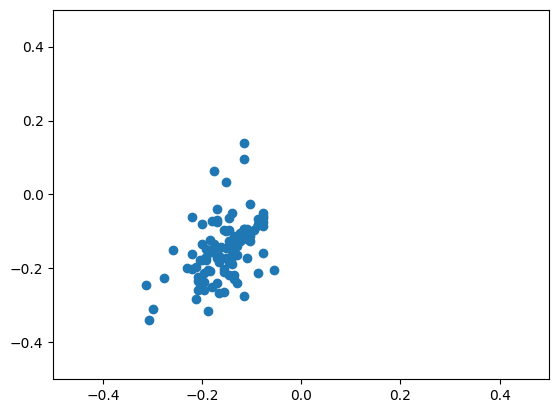

In [123]:
import matplotlib.pyplot as plt
inputs_np = inputs.to("cpu").numpy().round(3)
outputs_np = outputs.to("cpu").numpy().round(3)
mask = inputs_np<0.5

plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.scatter(inputs_np[mask][:100], outputs_np[mask][:100])

In [127]:
batch_size=256
train_set_drug  = dataset(X_train_drug, y_train_drug)
val_set_drug  = dataset(X_val_drug, y_val_drug)
train_dl_drug = DataLoader(train_set_drug, batch_size=batch_size, shuffle=True)
val_dl_drug = DataLoader(val_set_drug, batch_size=1, shuffle=True)
xi, yi = next(iter(train_dl_drug))

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

[I 2023-08-24 15:59:01,277] A new study created in memory with name: no-name-7928a3f7-6d42-486d-9ef1-79f5cbcbc7bc


EPOCH 10: LOSS train 0.8964327971140543 valid 0.9187698364257812
EPOCH 20: LOSS train 0.735660175482432 valid 0.8696612119674683
EPOCH 30: LOSS train 0.6578816970189413 valid 0.841172456741333
EPOCH 40: LOSS train 0.5808011690775553 valid 0.820204496383667
EPOCH 50: LOSS train 0.5016927619775137 valid 0.8065064549446106
EPOCH 60: LOSS train 0.4470178186893463 valid 0.792937695980072
EPOCH 70: LOSS train 0.40131019552548725 valid 0.7838071584701538
EPOCH 80: LOSS train 0.33746330936749774 valid 0.7746938467025757
EPOCH 90: LOSS train 0.2870992024739583 valid 0.7652873992919922
EPOCH 100: LOSS train 0.2520986000696818 valid 0.7589479684829712
EPOCH 110: LOSS train 0.21655350923538208 valid 0.7564115524291992
EPOCH 120: LOSS train 0.1925071726242701 valid 0.7516952157020569
EPOCH 130: LOSS train 0.16322414577007294 valid 0.7490956783294678
EPOCH 140: LOSS train 0.15513590474923453 valid 0.7476940155029297
EPOCH 150: LOSS train 0.13686367372671762 valid 0.7477654218673706
EPOCH 160: LOSS t

[I 2023-08-24 16:00:58,622] Trial 0 finished with value: 0.7264183163642883 and parameters: {'weight_decay': 2.0742200279799252e-07, 'learning_rate': 0.0004054200648538034, 'dropout': 0.006690157715080158}. Best is trial 0 with value: 0.7264183163642883.


EPOCH 500: LOSS train 0.023595905552307766 valid 0.7264183163642883
EPOCH 10: LOSS train 0.951216459274292 valid 0.9843992590904236
EPOCH 20: LOSS train 0.9661097923914591 valid 0.9843155145645142
EPOCH 30: LOSS train 0.9769763350486755 valid 0.9841616153717041
Epoch 00031: reducing learning rate of group 0 to 5.5889e-06.


[I 2023-08-24 16:01:08,133] Trial 1 finished with value: 0.9839949607849121 and parameters: {'weight_decay': 4.203455077345441e-08, 'learning_rate': 1.117773330334623e-05, 'dropout': 0.0952681856404866}. Best is trial 0 with value: 0.7264183163642883.


EPOCH 40: LOSS train 0.992885410785675 valid 0.9839949607849121
EPOCH 10: LOSS train 0.9817602038383484 valid 0.9846104383468628
EPOCH 20: LOSS train 1.0348960955937703 valid 0.9844990968704224
EPOCH 30: LOSS train 0.979311486085256 valid 0.9841519594192505
EPOCH 40: LOSS train 0.9859962662061056 valid 0.9827821850776672
Epoch 00044: reducing learning rate of group 0 to 1.1116e-05.
EPOCH 50: LOSS train 0.9563847581545512 valid 0.9793707728385925
EPOCH 60: LOSS train 0.9439239700635275 valid 0.9754704236984253
EPOCH 70: LOSS train 0.9693473776181539 valid 0.9726516008377075
Epoch 00078: reducing learning rate of group 0 to 5.5580e-06.
EPOCH 80: LOSS train 0.9469285011291504 valid 0.9708676934242249


[I 2023-08-24 16:01:28,502] Trial 2 finished with value: 0.9703244566917419 and parameters: {'weight_decay': 4.15138552676534e-05, 'learning_rate': 2.223214019936377e-05, 'dropout': 0.2413583926687849}. Best is trial 0 with value: 0.7264183163642883.


EPOCH 10: LOSS train 0.8919724424680074 valid 0.9378631711006165
EPOCH 20: LOSS train 0.7777864138285319 valid 0.8827853202819824
EPOCH 30: LOSS train 0.7335690855979919 valid 0.8555580973625183
EPOCH 40: LOSS train 0.6549035310745239 valid 0.8372163772583008
EPOCH 50: LOSS train 0.6154762705167135 valid 0.8238299489021301
EPOCH 60: LOSS train 0.57394939661026 valid 0.8137056827545166
EPOCH 70: LOSS train 0.5238625804583231 valid 0.8031138181686401
EPOCH 80: LOSS train 0.4946559965610504 valid 0.793481171131134
EPOCH 90: LOSS train 0.4698922435442607 valid 0.7873779535293579
EPOCH 100: LOSS train 0.4195818801720937 valid 0.7816359400749207
EPOCH 110: LOSS train 0.3874383866786957 valid 0.775000274181366
EPOCH 120: LOSS train 0.35152796904246014 valid 0.7669376134872437
EPOCH 130: LOSS train 0.326005220413208 valid 0.7634682059288025
EPOCH 140: LOSS train 0.3027735749880473 valid 0.7595819234848022
EPOCH 150: LOSS train 0.2903686265150706 valid 0.7560952305793762
EPOCH 160: LOSS train 0

[I 2023-08-24 16:03:33,424] Trial 3 finished with value: 0.7246367931365967 and parameters: {'weight_decay': 5.898295395253151e-06, 'learning_rate': 0.0002627818048917611, 'dropout': 0.025916582435828884}. Best is trial 3 with value: 0.7246367931365967.


EPOCH 500: LOSS train 0.06845741967360179 valid 0.7246367931365967
EPOCH 10: LOSS train 0.9985620776812235 valid 0.9844756722450256
EPOCH 20: LOSS train 1.016975224018097 valid 0.9842193722724915
EPOCH 30: LOSS train 0.961137056350708 valid 0.9833748936653137
Epoch 00036: reducing learning rate of group 0 to 7.3645e-06.
EPOCH 40: LOSS train 0.9730969866116842 valid 0.98159259557724


[I 2023-08-24 16:03:43,668] Trial 4 finished with value: 0.9805439114570618 and parameters: {'weight_decay': 3.7266483575972175e-06, 'learning_rate': 1.4729021005959363e-05, 'dropout': 0.008743042594170646}. Best is trial 3 with value: 0.7246367931365967.
[I 2023-08-24 16:03:43,919] Trial 5 pruned. 
[I 2023-08-24 16:03:44,200] Trial 6 pruned. 
[I 2023-08-24 16:03:44,557] Trial 7 pruned. 
[I 2023-08-24 16:03:44,844] Trial 8 pruned. 
[I 2023-08-24 16:03:45,126] Trial 9 pruned. 


EPOCH 10: LOSS train 0.9588246941566467 valid 0.9845335483551025


[I 2023-08-24 16:03:47,843] Trial 10 pruned. 


EPOCH 10: LOSS train 0.8747256000836691 valid 0.9270272254943848
EPOCH 20: LOSS train 0.7646091977755228 valid 0.8801366686820984
EPOCH 30: LOSS train 0.7038793365160624 valid 0.8500660061836243
EPOCH 40: LOSS train 0.6081476012865702 valid 0.8313676714897156
EPOCH 50: LOSS train 0.5615212321281433 valid 0.8169065117835999
EPOCH 60: LOSS train 0.46607200304667157 valid 0.8064845204353333
EPOCH 70: LOSS train 0.43679653604825336 valid 0.7933388948440552
EPOCH 80: LOSS train 0.38767583171526593 valid 0.7843006253242493
EPOCH 90: LOSS train 0.33839816848436993 valid 0.7754285335540771
EPOCH 100: LOSS train 0.3081312378247579 valid 0.7693676352500916
EPOCH 110: LOSS train 0.28139880299568176 valid 0.7649153470993042


[I 2023-08-24 16:04:14,112] Trial 11 pruned. 


EPOCH 10: LOSS train 0.9078738490740458 valid 0.9338170289993286
EPOCH 20: LOSS train 0.8005250891049703 valid 0.8890096545219421
EPOCH 30: LOSS train 0.7068562110265096 valid 0.8619912266731262
EPOCH 40: LOSS train 0.6463988224665324 valid 0.8406268954277039


[I 2023-08-24 16:04:24,466] Trial 12 pruned. 


EPOCH 10: LOSS train 0.9222878217697144 valid 0.9636880159378052
EPOCH 20: LOSS train 0.8707720637321472 valid 0.9342678785324097
EPOCH 30: LOSS train 0.8585448265075684 valid 0.9104251265525818
EPOCH 40: LOSS train 0.8641272187232971 valid 0.8953218460083008


[I 2023-08-24 16:04:35,031] Trial 13 pruned. 


EPOCH 10: LOSS train 0.8664694825808207 valid 0.9002593755722046
EPOCH 20: LOSS train 0.719032883644104 valid 0.860633134841919
EPOCH 30: LOSS train 0.6373923420906067 valid 0.8339985609054565
EPOCH 40: LOSS train 0.5355844000975291 valid 0.8143650889396667
EPOCH 50: LOSS train 0.4605963130791982 valid 0.8016321659088135
EPOCH 60: LOSS train 0.4268210728963216 valid 0.7890103459358215
EPOCH 70: LOSS train 0.4153373638788859 valid 0.7804701328277588
EPOCH 80: LOSS train 0.34659204880396527 valid 0.7723497152328491
EPOCH 90: LOSS train 0.31361572941144306 valid 0.7708794474601746
EPOCH 100: LOSS train 0.28423810998598736 valid 0.7650997042655945
EPOCH 110: LOSS train 0.26771198709805805 valid 0.7583284378051758
EPOCH 120: LOSS train 0.24648148814837137 valid 0.7678614258766174


[I 2023-08-24 16:05:04,217] Trial 14 pruned. 
[I 2023-08-24 16:05:04,507] Trial 15 pruned. 


EPOCH 10: LOSS train 0.9149225950241089 valid 0.9238418936729431
EPOCH 20: LOSS train 0.8410022258758545 valid 0.8766993880271912
EPOCH 30: LOSS train 0.7531596223513285 valid 0.854283332824707
EPOCH 40: LOSS train 0.6693061987559 valid 0.8387368321418762


[I 2023-08-24 16:05:15,444] Trial 16 pruned. 


EPOCH 10: LOSS train 0.9518271287282308 valid 0.9570673108100891
EPOCH 20: LOSS train 0.8650016585985819 valid 0.9091325402259827
EPOCH 30: LOSS train 0.7935507297515869 valid 0.8853872418403625
EPOCH 40: LOSS train 0.7390687465667725 valid 0.8699078559875488


[I 2023-08-24 16:05:27,197] Trial 17 pruned. 


EPOCH 10: LOSS train 0.8319852550824484 valid 0.916589617729187
EPOCH 20: LOSS train 0.7619730830192566 valid 0.8727059960365295
EPOCH 30: LOSS train 0.6676624814669291 valid 0.8481240272521973
EPOCH 40: LOSS train 0.6438319484392802 valid 0.8292450308799744
EPOCH 50: LOSS train 0.5345362226168314 valid 0.8135040998458862
EPOCH 60: LOSS train 0.4456770320733388 valid 0.8028504848480225
EPOCH 70: LOSS train 0.39529483517011005 valid 0.7880486249923706
EPOCH 80: LOSS train 0.34574905037879944 valid 0.7800403833389282
EPOCH 90: LOSS train 0.3126489718755086 valid 0.7749796509742737
EPOCH 100: LOSS train 0.26464299857616425 valid 0.7678115367889404
EPOCH 110: LOSS train 0.24597961703936258 valid 0.763232409954071


[I 2023-08-24 16:06:01,163] Trial 18 pruned. 
[I 2023-08-24 16:06:01,703] Trial 19 pruned. 


EPOCH 10: LOSS train 0.8898886640866598 valid 0.9434162378311157
EPOCH 20: LOSS train 0.8169260223706564 valid 0.8894577026367188
EPOCH 30: LOSS train 0.7374055782953898 valid 0.8653506636619568
EPOCH 40: LOSS train 0.6889314850171407 valid 0.8487825393676758


[I 2023-08-24 16:06:14,009] Trial 20 pruned. 


EPOCH 10: LOSS train 0.9994248946507772 valid 0.9840867519378662
EPOCH 20: LOSS train 0.9728068510691324 valid 0.980194091796875
EPOCH 30: LOSS train 0.9767831166585287 valid 0.9664987921714783


{'weight_decay': 1.4343876100314803e-06, 'learning_rate': 0.00045871647446227656, 'dropout': 0.05777989426470749}